In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import joblib

In [14]:
# 1. Load data
df = pd.read_csv('../data/breast_tumor_data/breast-cancer-wisconsin-data_data.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.dropna(axis=1, how='all')

In [15]:
# 2. Drop obvious non-feature columns (like ID)
feature_drop = [col for col in df.columns if 'id' in col.lower()]
df = df.drop(feature_drop, axis=1)

In [16]:
# 3. Encode target
y = df['diagnosis'].map({'M': 1, 'B': 0})
X = df.drop('diagnosis', axis=1)

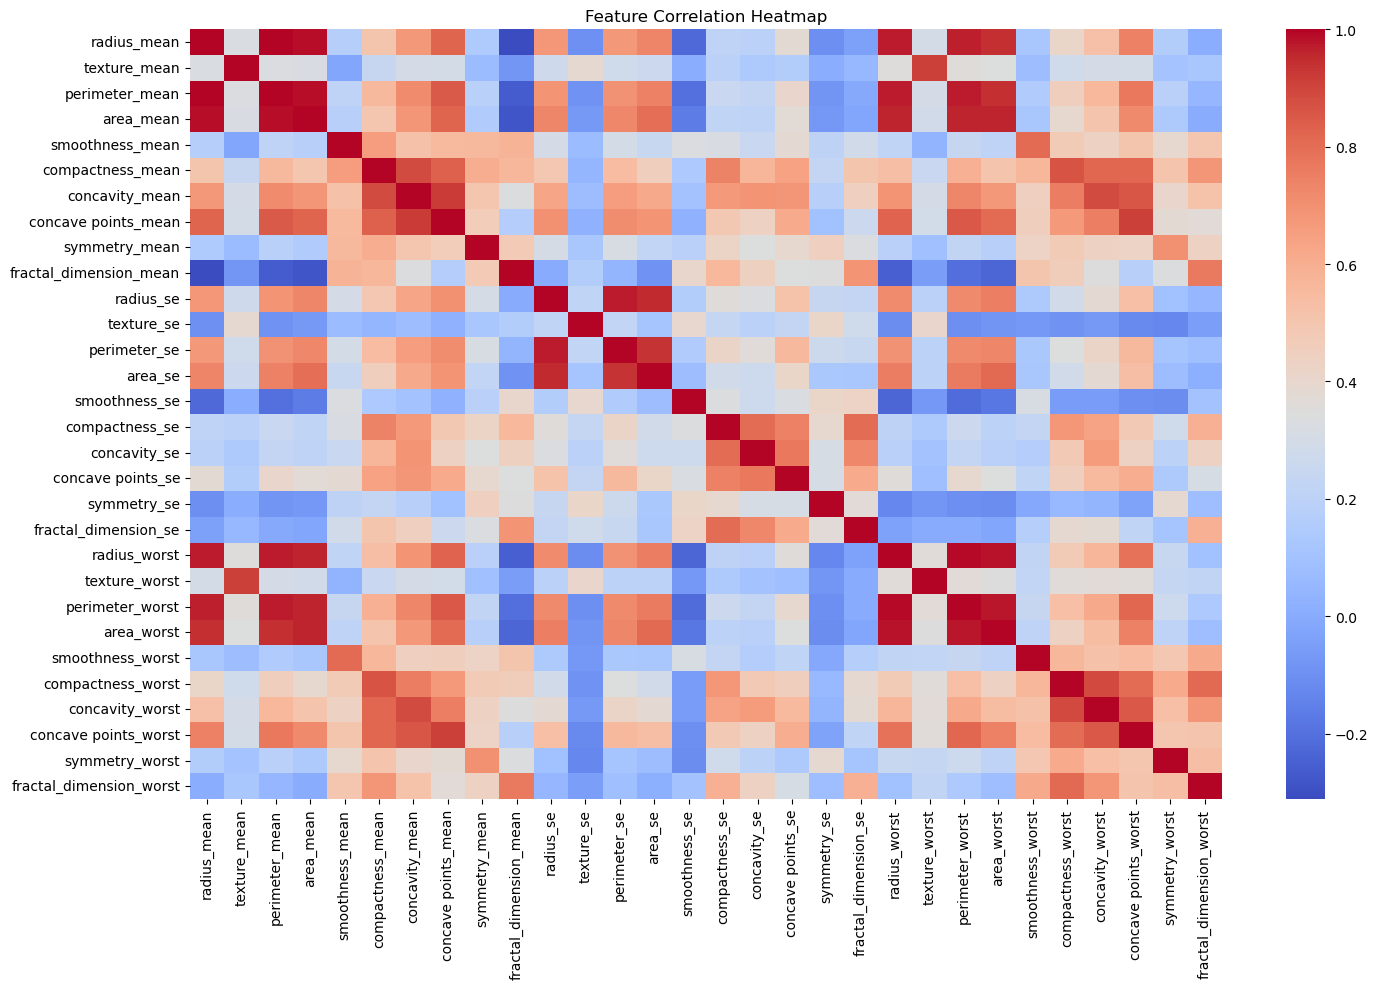

In [17]:
# 4. Basic EDA: heatmap
plt.figure(figsize=(15,10))
sns.heatmap(X.corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

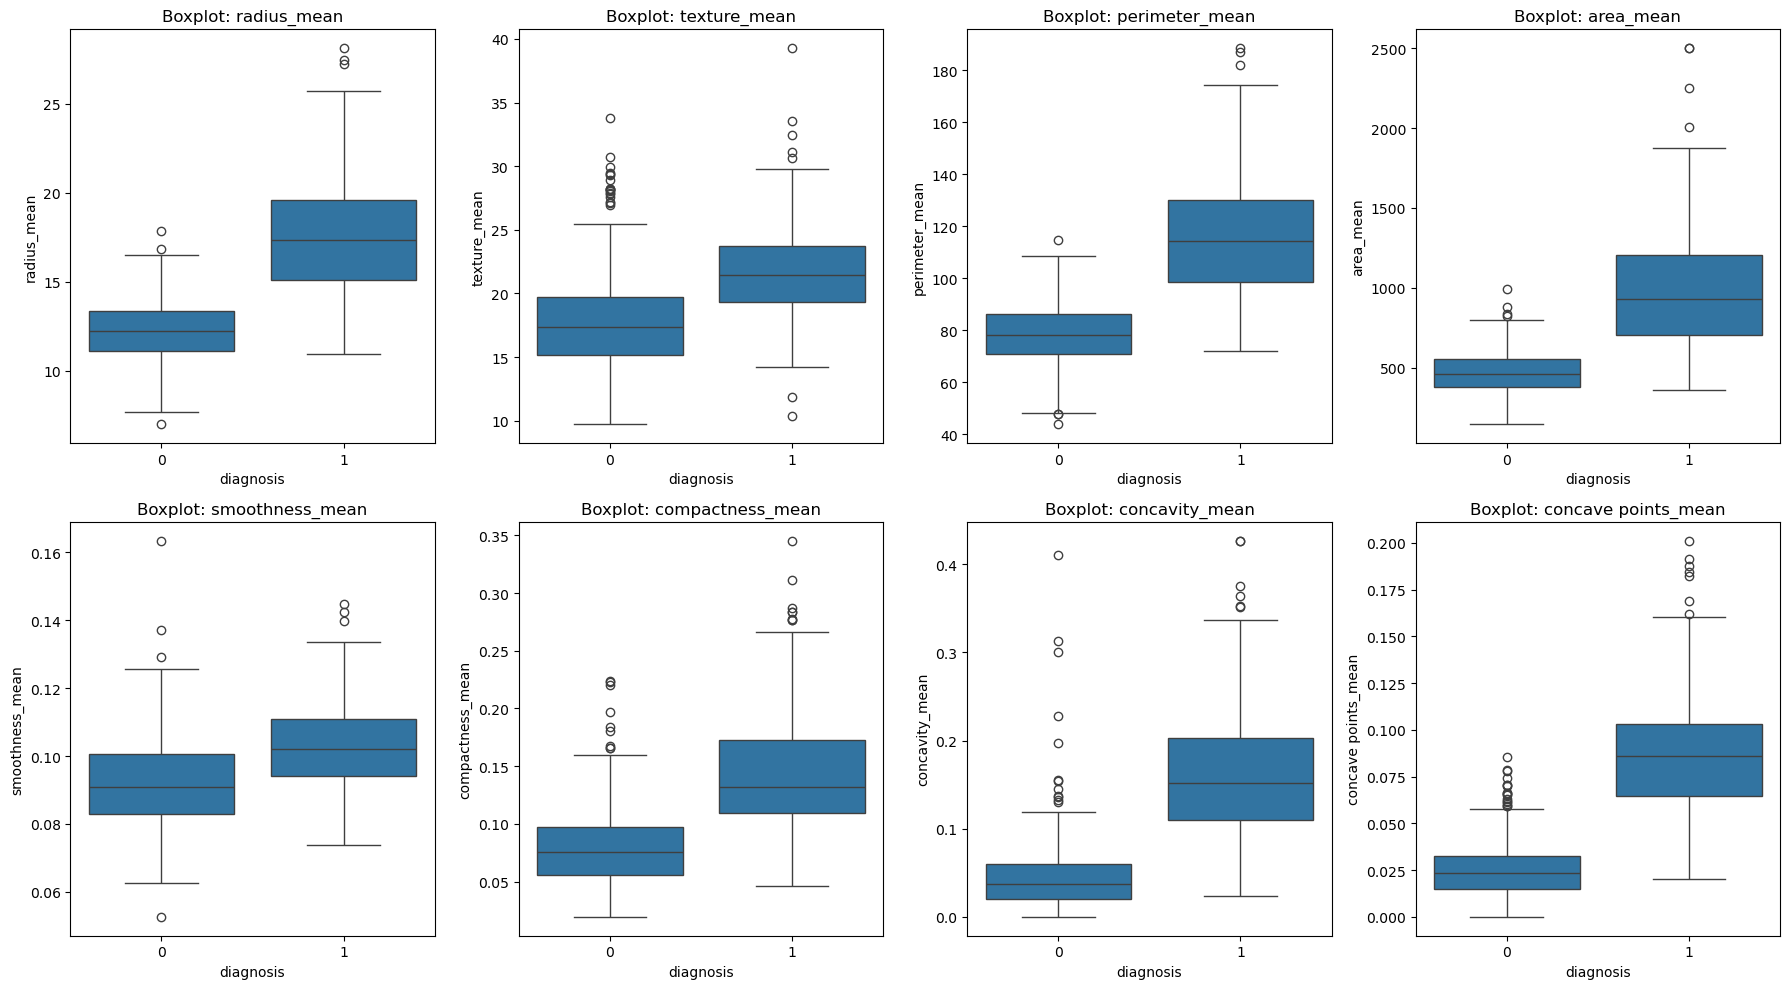

In [18]:
# 5. Basic boxplots (first 8 features for brevity: adjust as you like)
plt.figure(figsize=(18, 10))
for i, col in enumerate(X.columns[:8], 1):
    plt.subplot(2,4,i)
    sns.boxplot(x=y, y=X[col])
    plt.title(f'Boxplot: {col}')
plt.tight_layout()
plt.show()

In [19]:
# 6. Simple feature engineering example
X['area_mean_log'] = np.log1p(X['area_mean'])
X['concavity_mean_sqrt'] = np.sqrt(X['concavity_mean'])
X['texture_ratio'] = X['texture_mean'] / (X['texture_worst'] + 1)

In [20]:
# 7. Remove nulls just in case (shouldn't be any for this dataset)
X = X.dropna(axis=1, how='any')
X = X.fillna(X.median())

In [21]:
# 8. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
# 9. Pipeline: StandardScaler + SVC
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(probability=True, random_state=42))
])

In [23]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:,1]

In [24]:
# 10. Reports
print("Classification Report:\n", classification_report(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114

Accuracy: 0.9649122807017544


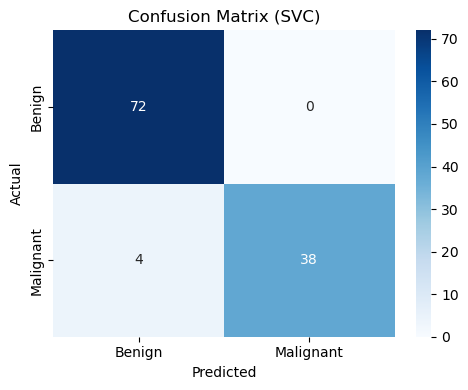

In [25]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (SVC)')
plt.tight_layout()
plt.show()

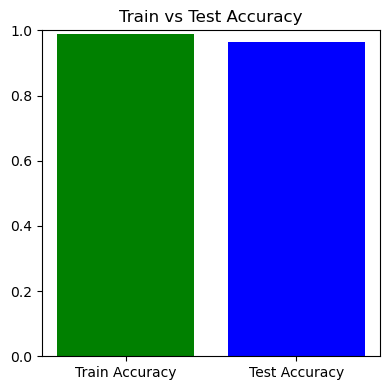

In [26]:
# 11. Train vs Test accuracy bar
train_acc = accuracy_score(y_train, pipe.predict(X_train))
test_acc = accuracy_score(y_test, y_pred)
plt.figure(figsize=(4,4))
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc, test_acc], color=['green','blue'])
plt.title('Train vs Test Accuracy')
plt.ylim(0,1)
plt.tight_layout()
plt.show()

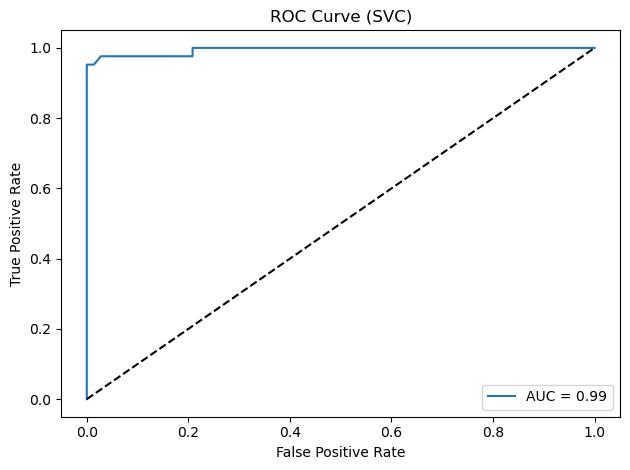

In [27]:
# 12. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (SVC)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

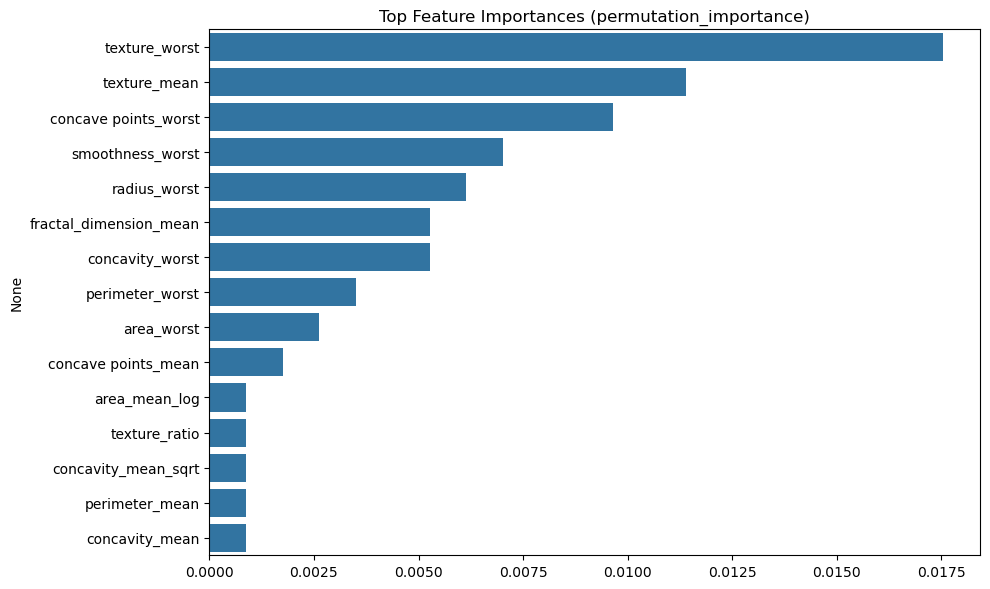

In [28]:
# 13. Permutation feature importance
result = permutation_importance(pipe, X_test, y_test, n_repeats=10, random_state=42)
imp_sorted_idx = np.argsort(result.importances_mean)[::-1][:15]
plt.figure(figsize=(10,6))
sns.barplot(x=result.importances_mean[imp_sorted_idx], y=X_test.columns[imp_sorted_idx])
plt.title('Top Feature Importances (permutation_importance)')
plt.tight_layout()
plt.show()

In [30]:
# 14. Save as a pipeline pkl
joblib.dump(pipe, '../trained_models/breast_cancer_pipeline.pkl')
print("Pipeline model saved as 'models/breast_cancer/svc_breast_cancer_pipeline.pkl'")

Pipeline model saved as 'models/breast_cancer/svc_breast_cancer_pipeline.pkl'
